In [52]:
import xarray as xr
from sea_breeze import sea_breeze_filters, load_model_data, sea_breeze_funcs, utils
from dask.distributed import Client
import os
import pandas as pd
from dask.distributed import Client, progress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage
import warnings

from sea_breeze.sea_breeze_filters import *

In [53]:
client = Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45793 instead
  warnings.warn(


Modifying workers


/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"Attempted illegal binding: {(sorted(list(self.slots_available - taken_slots))[:self.worker.state.nthreads])}")
/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"Attempted illegal binding: {(sorted(list(self.slots_available - taken_slots))[:self.worker.state.nthreads])}")
/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"Attempted illegal binding: {(sorted(list(self.slots_available - taken_slots))[:self.worker.state.nthreads])}")
/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"Attempted illegal binding: {(sorted(list(self.slots_available - taken_slots))[:self.worker.state.nthreads])}")
/g/data/hh5/public/apps/dask-optimiser/schedplugin.py:160: UserWarning: Attempted illegal binding: []
  warn(f"A

In [54]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0012.gadi.nci.org.au/63384/proxy/45793/status,
Dashboard: /node/gadi-cpu-bdw-0012.gadi.nci.org.au/63384/proxy/45793/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41423,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0012.gadi.nci.org.au/63384/proxy/45793/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37553,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0012.gadi.nci.org.au/63384/proxy/37353/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43115,


In [55]:
#Set up paths to sea_breeze_funcs data output and other inputs
path = "/g/data/gb02/ab4502/"
fc_field_path = path + "sea_breeze_detection/aus2200/Fc_mjo-elnino_201601010000_201601312300.zarr"
fc_smooth_field_path = path + "sea_breeze_detection/aus2200_smooth_s2/Fc_mjo-elnino_201601010000_201601312300.zarr"
angle_ds_path = path + "coastline_data/aus2200.nc"
hourly_change_path = path+ "sea_breeze_detection/"+"aus2200"+"/F_hourly_mjo-elnino_201601010000_201601312300.zarr"

In [56]:
t1 = "2016-01-06 6:00"
t2 = "2016-01-06 6:00"
# t1 = "2016-01-07 08:00"
# t2 = "2016-01-07 08:00"
#lat_slice, lon_slice = utils.get_perth_large_bounds()
lat_slice = slice(-45.7,-6.9)
lon_slice = slice(108,158.5)

In [57]:
def rotate_wind(u,v,theta):

    """
    Rotate u and v wind components to be cross-shore and along-shore, based on angle of coastline orientation, theta.

    ## Input
    * u: xarray dataarray of u winds in m/s
    * v: xarray dataarray of v winds in m/s
    * theta: xarray dataarray of coastline orientation angles from N

    ## Output
    * uprime: xarray dataarray of wind component parallel to the coast
    * vprime: xarray dataarray of wind component perpendicular to the coast
    """

    #Rotate angle to be perpendicular to theta, from E (i.e. mathamatical angle definition)
    rotated_angle=(((theta)%360-90)%360) + 90   
    
    #Define normal angle vectors, pointing onshore
    cx, cy = [-np.cos(np.deg2rad(rotated_angle)), np.sin(np.deg2rad(rotated_angle))]
    
    #Define normal angle vectors, pointing alongshore
    ax, ay = [-np.cos(np.deg2rad(rotated_angle - 90)), np.sin(np.deg2rad(rotated_angle - 90))]    
    
    #Calculate the wind component perpendicular and parallel to the coast by using the normal unit vectors
    uprime = ((u*ax) + (v*ay))
    vprime = ((u*cx) + (v*cy))

    return uprime, vprime    

Fc = xr.open_dataset(
        fc_field_path,chunks="auto"
        ).Fc.sel(lat=lat_slice,lon=lon_slice,time=slice(t1,t2)) 
Fc_smooth = xr.open_dataset(
        fc_smooth_field_path,chunks="auto"
        ).Fc.sel(lat=lat_slice,lon=lon_slice,time=slice(t1,t2)) 

aus2200_vas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "vas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks={"time":1,"lat":-1,"lon":-1},
        staggered="lat"),
          "10min")
aus2200_uas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "uas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks={"time":1,"lat":-1,"lon":-1},
        staggered="lon"),
          "10min")
aus2200_tas = load_model_data.load_aus2200_variable(
        "tas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks={"time":1,"lat":-1,"lon":-1}
        )
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,path_to_load=angle_ds_path,lat_slice=lat_slice,lon_slice=lon_slice
    )
uprime,vprime=sea_breeze_funcs.rotate_wind(aus2200_uas,aus2200_vas,angle_ds["angle_interp"])
_,lsm = load_model_data.load_aus2200_static(
        "mjo-elnino",lon_slice,lat_slice
        )
hourly_change_ds = xr.open_dataset(
        hourly_change_path,chunks={},drop_variables="dqu_dt"
        ).sel(lat=lat_slice,lon=lon_slice,time=slice(t1,t2)).chunk({"time":1,"lat":-1,"lon":-1})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/si

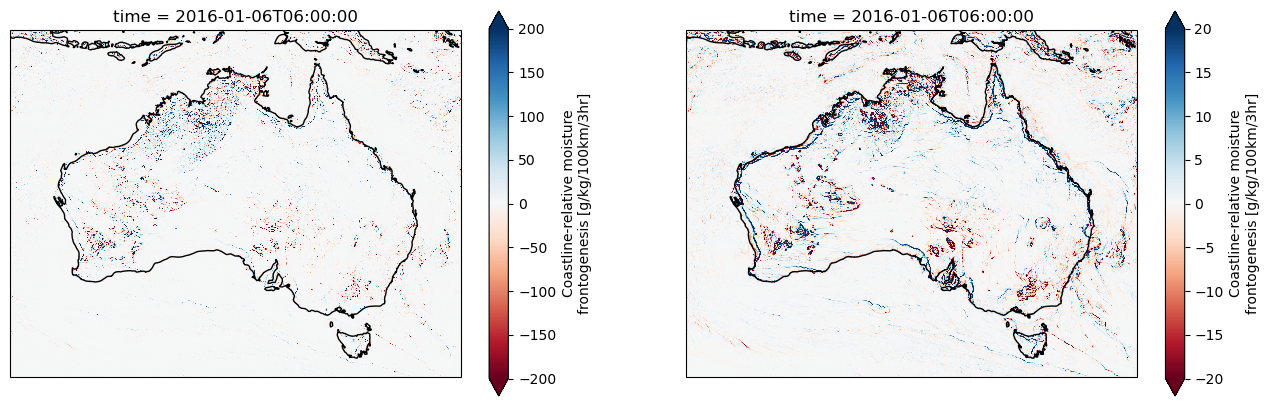

In [58]:
plt.figure(figsize=[16,5])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
Fc.plot(vmin=-200,vmax=200,cmap="RdBu")
ax.coastlines()

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
Fc_smooth.plot(vmin=-20,vmax=20,cmap="RdBu")
ax.coastlines()

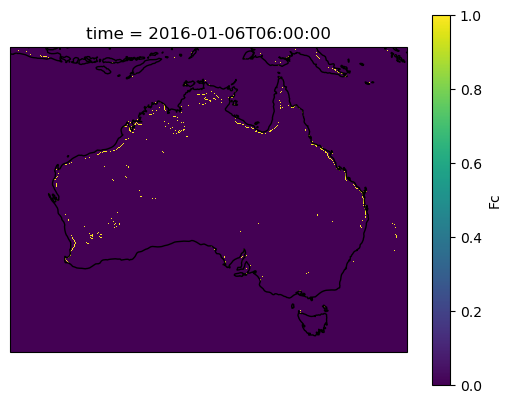

In [74]:
ax=plt.axes(projection=ccrs.PlateCarree())
(Fc_smooth > 60).plot()
ax.coastlines()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 51.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.16 MiB.
This may cause some slowdo

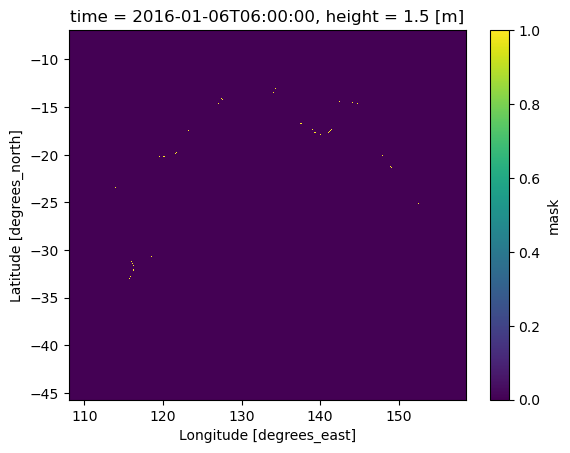

In [59]:
field = Fc

kwargs = {
    "orientation_filter":True,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":True,                    
    "temperature_change_filter":True,
    "humidity_change_filter":True,
    "wind_change_filter":True,
    "propagation_speed_filter":True,
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    "land_sea_temperature_diff_thresh":0,
    "propagation_speed_thresh":0,
    }

ds = sea_breeze_filters.filter_3d(
    field,
    threshold="fixed",
    threshold_value=627,
    hourly_change_ds=hourly_change_ds,
    ta=aus2200_tas,
    vprime=vprime.drop_vars("height"),
    lsm=lsm,
    angle_ds=angle_ds,
    props_df_out_path="/scratch/ng72/ab4502/tmp/props_df",
    save_mask=False,
    **kwargs)

ds.mask.plot()

2025-02-12 10:47:13,677 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:14,523 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:15,383 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:16,394 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:17,423 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:18,651 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:19,942 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2025-02-12 10:49:16,046 - distributed.utils_perf - WARNING - full garbage collections took

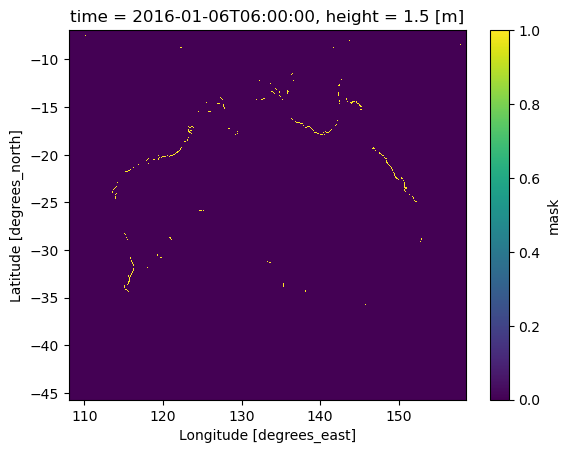

In [76]:
field = Fc_smooth

kwargs = {
    "orientation_filter":True,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":True,                    
    "temperature_change_filter":True,
    "humidity_change_filter":True,
    "wind_change_filter":True,
    "propagation_speed_filter":True,
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    "land_sea_temperature_diff_thresh":0,
    "propagation_speed_thresh":0,
    }

ds = sea_breeze_filters.filter_3d(
    field,
    threshold="fixed",
    threshold_value=60,
    hourly_change_ds=hourly_change_ds,
    ta=aus2200_tas,
    vprime=vprime.drop_vars("height"),
    lsm=lsm,
    angle_ds=angle_ds,
    props_df_out_path="/scratch/ng72/ab4502/tmp/props_df",
    save_mask=False,
    **kwargs)

ds.mask.plot()

In [41]:
field = field.chunk({"time":1,"lat":-1,"lon":-1})

ds = sea_breeze_filters.binary_mask(field, 12.6)

ta=ta.chunk({"time":1,"lat":-1,"lon":-1})
ds = xr.merge((ds,ta.rename("ta")),join="exact")   
hourly_change_ds = hourly_change_ds.chunk({"time":1,"lat":-1,"lon":-1})
ds = xr.merge((ds,hourly_change_ds),join="exact").squeeze()

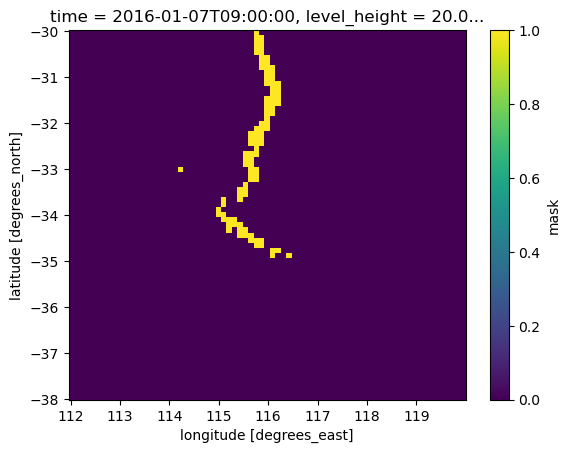

In [42]:
ds.mask.plot()

In [63]:
mask_options = sea_breeze_filters.Mask_Options().set_options(kwargs)

In [64]:
#Get time for data array
#time = pd.to_datetime(mask.time.values).strftime("%Y-%m-%d %H:%M")
time = ds.time.values

#From a binary (mask) array of candidate sea breeze objects, label from 1 to N
labels = skimage.measure.label(ds["mask"])
labels_da = xr.DataArray(labels, dims=ds["mask"].dims, coords=ds["mask"].coords)

#Using skimage, return properties for each candidate object
region_props = skimage.measure.regionprops(labels,spacing=(1,1))

#Get longitudes of image for the purpose of converting to local solar time
lons = ds.lon.values

#Get area of pixels using metpy
dx,dy,pixel_area = utils.metpy_grid_area(ds.lon,ds.lat)
pixel_area = xr.DataArray(pixel_area,coords=ds["mask"].coords,dims=ds["mask"].dims)

In [65]:
vprime.squeeze().groupby(labels_da.rename("label")).mean().to_series().drop(0)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


label
1   -4.791392
2   -3.238459
3   -2.826245
4   -3.134421
dtype: float64

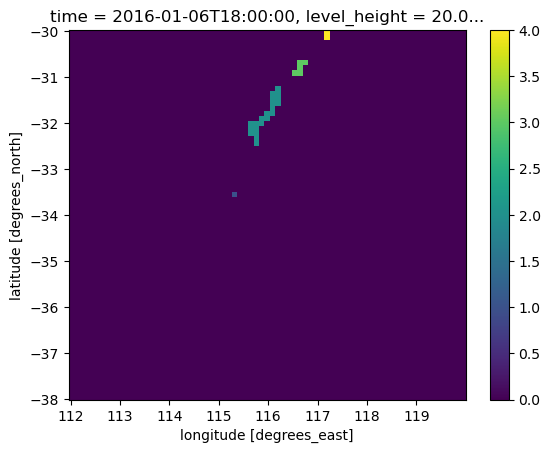

In [66]:
labels_da.plot()

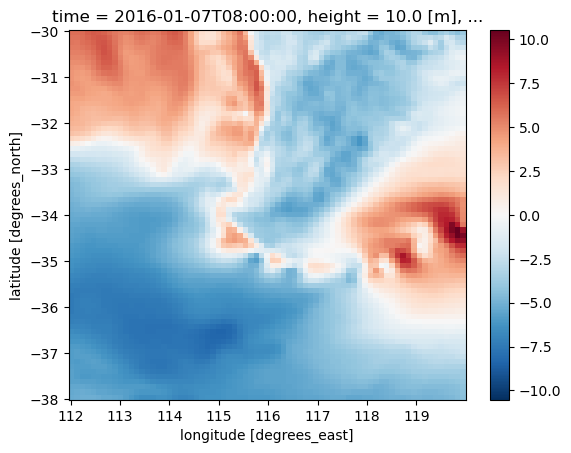

In [49]:
vprime.plot()

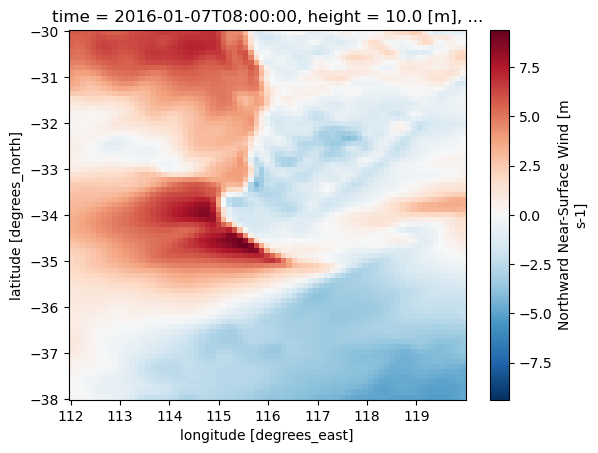

In [53]:
vas.plot()